In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import plotly.express as px
import logging
import os
import sys
# chemin racine
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
# import des modules du projet
from tests.forcast_test import encode_target, split_data, cross_validate, preprocess_data, generate_predictions, evaluate_model, plot_random_forest_tree, plot_feature_importances, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve;
from infrastructure.extract import extract
from settings.base import RAW_DATA_DIR


Répertoire confirmé -> c:\Users\ilysd\Desktop\FAC\Master 2\MLops\Projet\data\raw
Répertoire confirmé -> c:\Users\ilysd\Desktop\FAC\Master 2\MLops\Projet\data\formated
Répertoire confirmé -> c:\Users\ilysd\Desktop\FAC\Master 2\MLops\Projet\data\models
Fichier logging confirmé -> c:\Users\ilysd\Desktop\FAC\Master 2\MLops\Projet\settings\logging.yaml


# Data Import

In [3]:
print(RAW_DATA_DIR)


df = extract(RAW_DATA_DIR, 'prefix')


2024-12-19 07:35:44,702 - INFO - Calling extract with args: ('c:\\Users\\ilysd\\Desktop\\FAC\\Master 2\\MLops\\Projet\\data\\raw', 'prefix') and kwargs: {}


c:\Users\ilysd\Desktop\FAC\Master 2\MLops\Projet\data\raw


# Data Validation

Pas de colonne unnamed0, nombre totale de colonnes : 10

In [4]:
print(df .dtypes)

Age                  int64
Checking account    object
Credit amount        int64
Duration             int64
Housing             object
Job                  int64
Purpose             object
Risk                object
Saving accounts     object
Sex                 object
dtype: object


In [4]:
print(df)

     Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
0     67    male    2     own             NaN           little           1169   
1     22  female    2     own          little         moderate           5951   
2     49    male    1     own          little              NaN           2096   
3     45    male    2    free          little           little           7882   
4     53    male    2    free          little           little           4870   
..   ...     ...  ...     ...             ...              ...            ...   
995   31  female    1     own          little              NaN           1736   
996   40    male    3     own          little           little           3857   
997   38    male    2     own          little              NaN            804   
998   23    male    2    free          little           little           1845   
999   27    male    2     own        moderate         moderate           4576   

     Duration              

In [5]:
display(df)

,Age,Checking account,Credit amount,Duration,Housing,Job,Purpose,Risk,Saving accounts,Sex
0,67,little,1169,6,own,2,radio/TV,good,NaN,male
1,22,moderate,5951,48,own,2,radio/TV,bad,little,female
2,49,NaN,2096,12,own,1,education,good,little,male
3,45,little,7882,42,free,2,furniture/equipment,good,little,male
4,53,little,4870,24,free,2,car,bad,little,male
...,...,...,...,...,...,...,...,...,...,...
995,31,NaN,1736,12,own,1,furniture/equipment,good,little,female
996,40,little,3857,30,own,3,car,good,little,male
997,38,NaN,804,12,own,2,radio/TV,good,little,male
998,23,little,1845,45,free,2,radio/TV,bad,little,male


# Data Preparation

## Outliers

Variables numériques

In [9]:
# Identify numerical columns
numerical_cols = df.select_dtypes(include=np.number).columns

# Calculate IQR for numerical columns
Q1 = df[numerical_cols].quantile(0.25)
Q3 = df[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

# Detect outliers
outliers = ((df[numerical_cols] < (Q1 - 1.5 * IQR)) | (df[numerical_cols] > (Q3 + 1.5 * IQR)))

# Valeurs aberrantes uniques et leurs fréquences par colonne
outlier_frequencies = {}
for col in numerical_cols:
    # Extraire les valeurs aberrantes pour la colonne
    column_outliers = df[col][outliers[col]]
    
    # Compter les fréquences des valeurs aberrantes
    outlier_frequencies[col] = column_outliers.value_counts().sort_index()

# Afficher les fréquences des valeurs aberrantes par colonne
for col, frequencies in outlier_frequencies.items():
    print(f"Frequencies of outliers in column '{col}':")
    print(frequencies)
    print()

Frequencies of outliers in column 'Age':
Age
65    5
66    5
67    3
68    3
70    1
74    4
75    2
Name: count, dtype: int64

Frequencies of outliers in column 'Credit amount':
Credit amount
7966     1
7980     1
8065     1
8072     1
8086     1
        ..
15653    1
15672    1
15857    1
15945    1
18424    1
Name: count, Length: 72, dtype: int64

Frequencies of outliers in column 'Duration':
Duration
45     5
47     1
48    48
54     2
60    13
72     1
Name: count, dtype: int64

Frequencies of outliers in column 'Job':
Job
0     22
1    200
3    148
Name: count, dtype: int64



Variables catégorielles

In [8]:
# Afficher les modalités (valeurs uniques) de toutes les colonnes dans df
for column in df.columns:
    print(f"Modalités de la variable {column}:")
    print(df[column].unique())
    print()  # Ajoute une ligne vide pour séparer les résultats

Modalités de la variable Age:
[67 22 49 45 53 35 61 28 25 24 60 32 44 31 48 26 36 39 42 34 63 27 30 57
 33 37 58 23 29 52 50 46 51 41 40 66 47 56 54 20 21 38 70 65 74 68 43 55
 64 75 19 62 59]

Modalités de la variable Checking account:
['little' 'moderate' nan 'rich']

Modalités de la variable Credit amount:
[ 1169  5951  2096  7882  4870  9055  2835  6948  3059  5234  1295  4308
  1567  1199  1403  1282  2424  8072 12579  3430  2134  2647  2241  1804
  2069  1374   426   409  2415  6836  1913  4020  5866  1264  1474  4746
  6110  2100  1225   458  2333  1158  6204  6187  6143  1393  2299  1352
  7228  2073  5965  1262  3378  2225   783  6468  9566  1961  6229  1391
  1537  1953 14421  3181  5190  2171  1007  1819  2394  8133   730  1164
  5954  1977  1526  3965  4771  9436  3832  5943  1213  1568  1755  2315
  1412 12612  2249  1108   618  1409   797  3617  1318 15945  2012  2622
  2337  7057  1469  2323   932  1919  2445 11938  6458  6078  7721  1410
  1449   392  6260  7855  1680  

Pas de présences d'aberrations sauf pour l'âge , que nous allons regrouper par le suite.

## Missing Values

In [10]:
valeurs_manquantes_pourcentage = (df.isna().sum()/len(df))*100
print(valeurs_manquantes_pourcentage)

Age                  0.0
Checking account    39.4
Credit amount        0.0
Duration             0.0
Housing              0.0
Job                  0.0
Purpose              0.0
Risk                 0.0
Saving accounts     18.3
Sex                  0.0
dtype: float64


Deux variables, Checking account et Saving accounts, contiennent des valeurs manquantes. Ces colonnes correspondent à des services bancaires non choisis par les clients. Nous remplacerons les valeurs manquantes par de nouvelles modalités : No savings et No Checkings.

# Statistiques descriptives

## Statistiques univariées

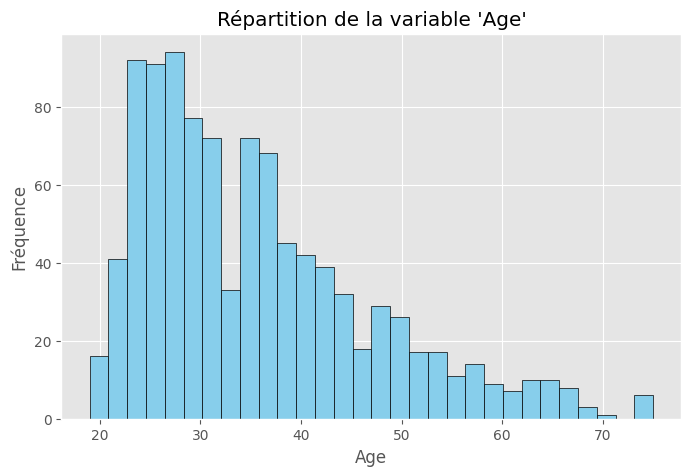

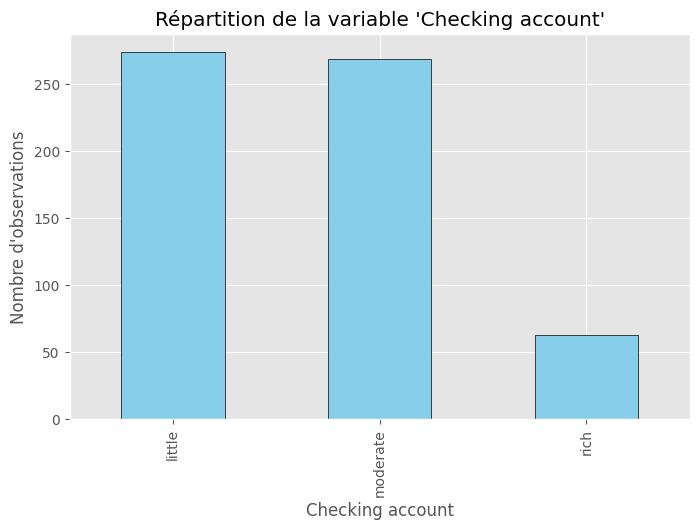

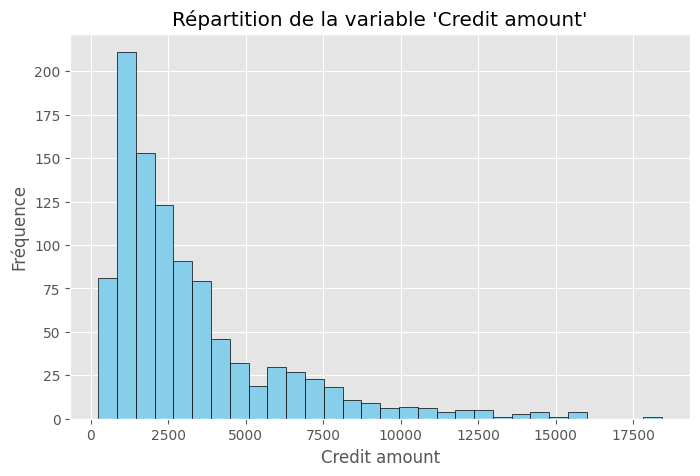

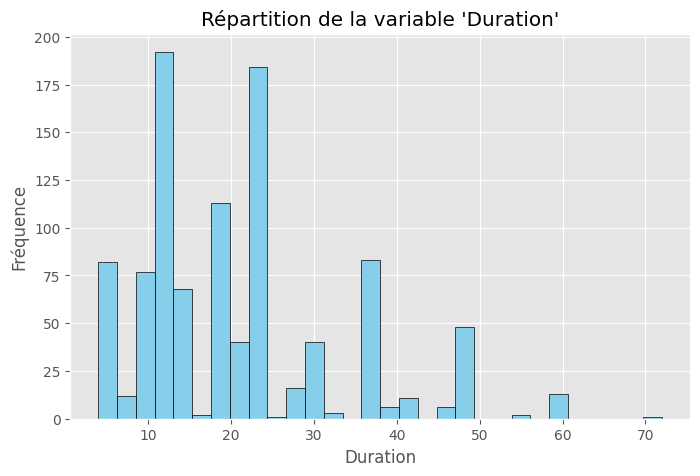

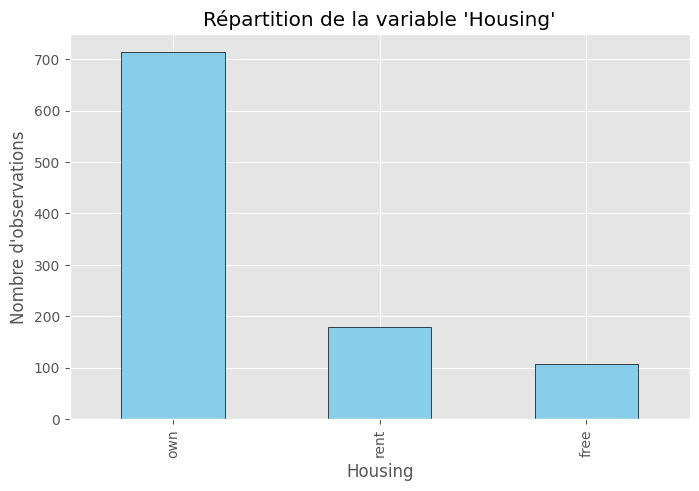

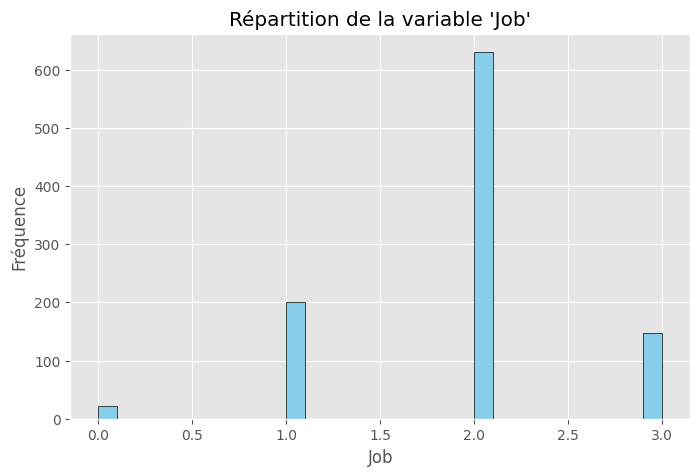

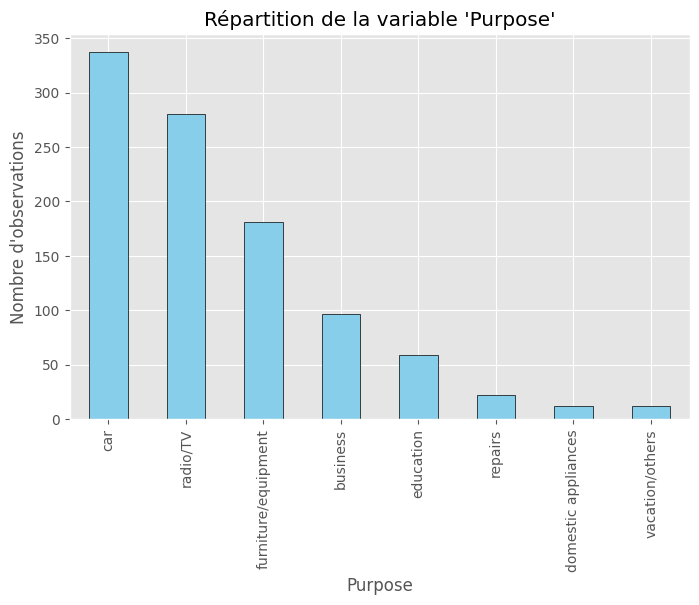

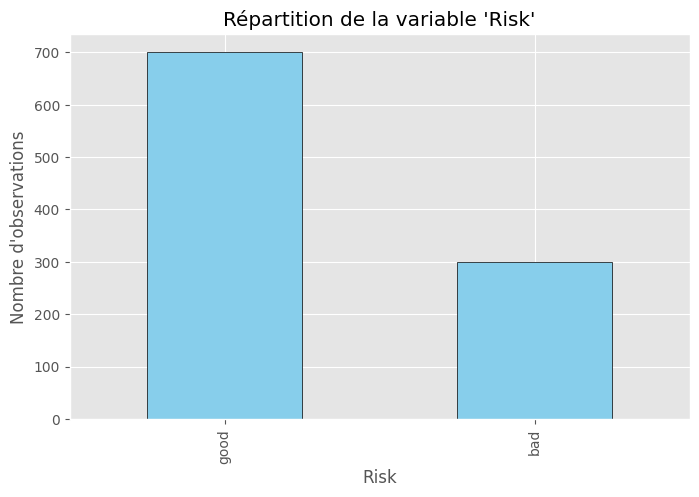

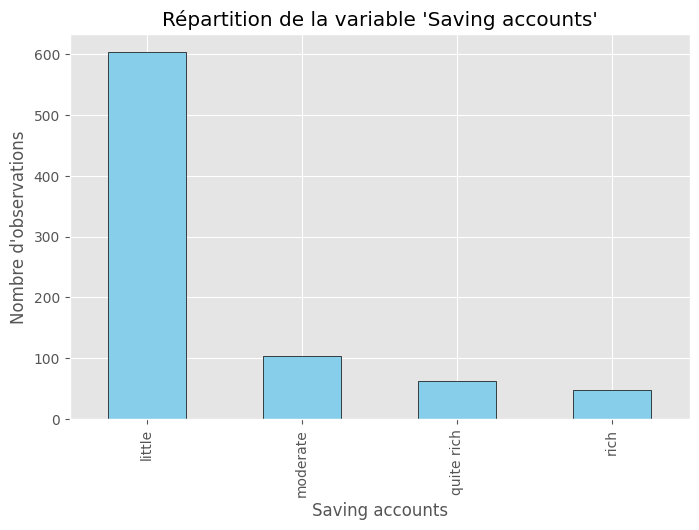

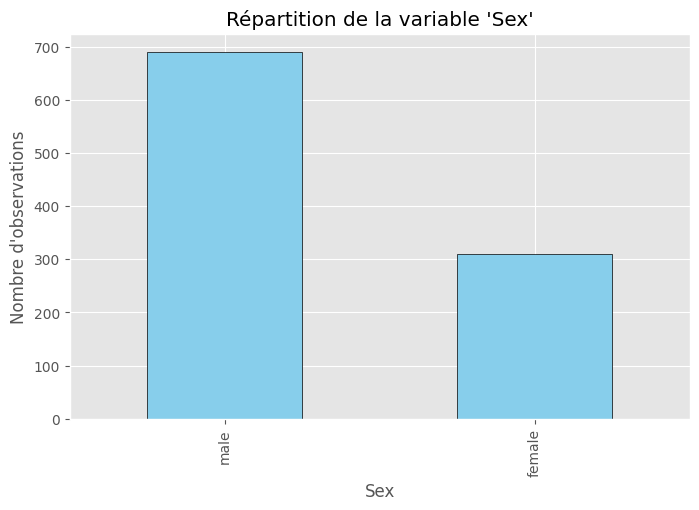

In [ ]:
# Supprimer la colonne Unnamed: 0 si elle existe (normalement supprimé dans l'extract)
df = df.drop(columns=["Unnamed: 0"], errors='ignore')

# Créer des histogrammes pour chaque variable
plt.style.use('ggplot')  # Style pour un affichage plus agréable

for column in df.columns:
    plt.figure(figsize=(8, 5))  # Taille de chaque histogramme
    if df[column].dtype in ['int64', 'float64']:
        # Histogramme pour variables numériques
        plt.hist(df[column], bins=30, color='skyblue', edgecolor='black')
        plt.title(f"Répartition de la variable '{column}'")
        plt.xlabel(column)
        plt.ylabel("Fréquence")
    else:
        # Diagramme en barres pour variables catégorielles
        df[column].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
        plt.title(f"Répartition de la variable '{column}'")
        plt.xlabel(column)
        plt.ylabel("Nombre d'observations")
    plt.show()


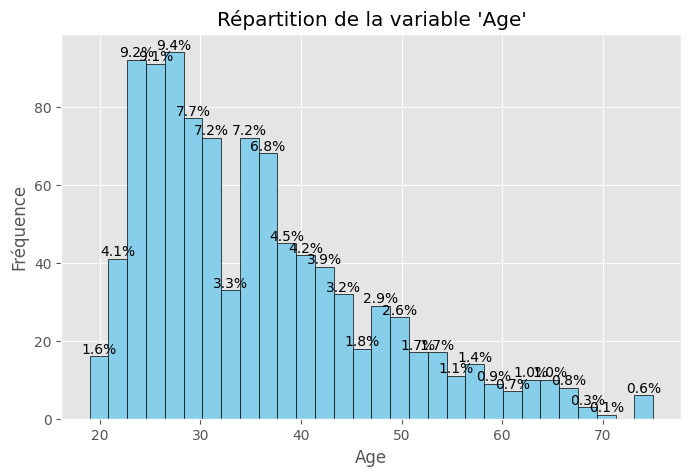

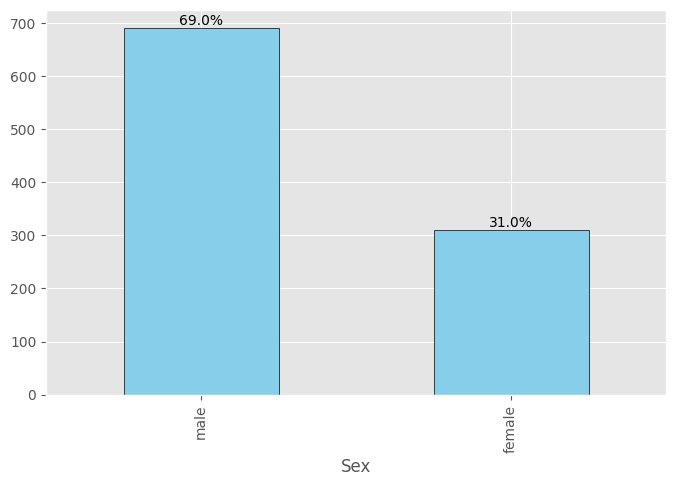

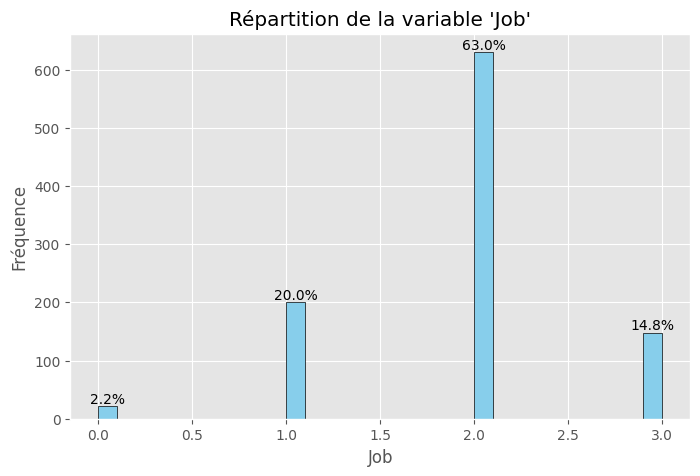

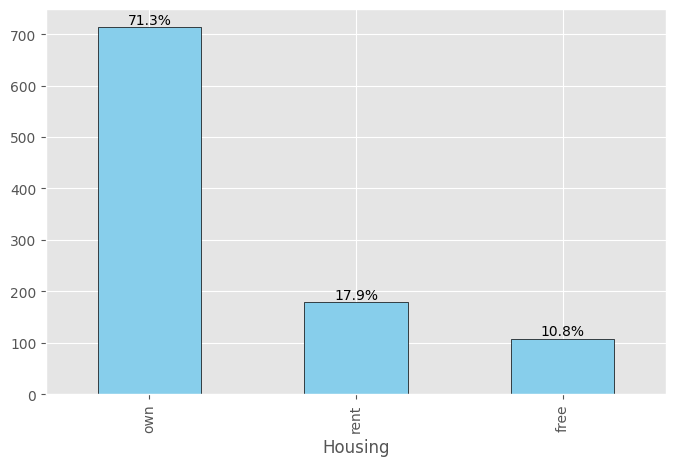

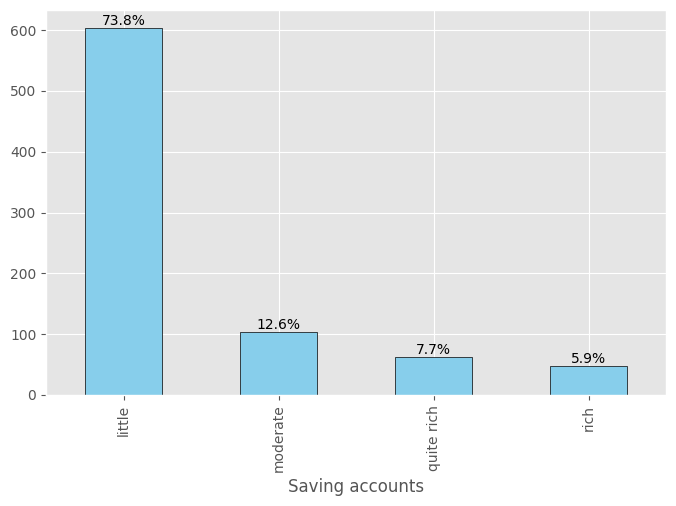

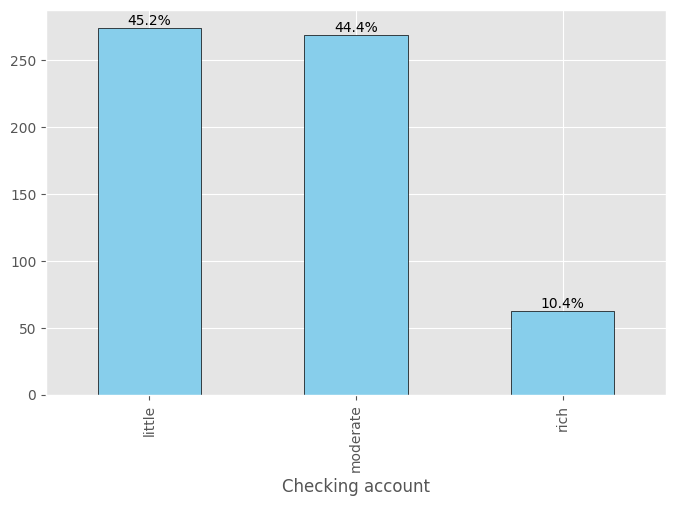

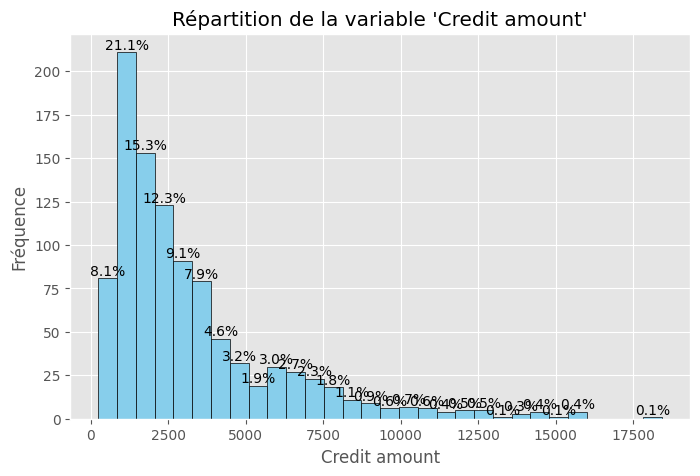

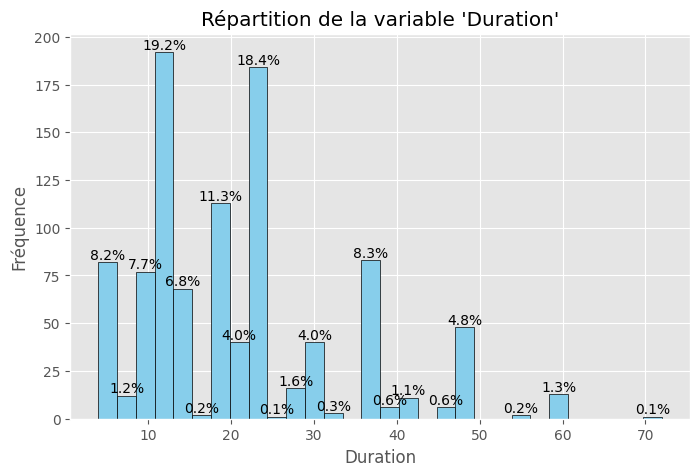

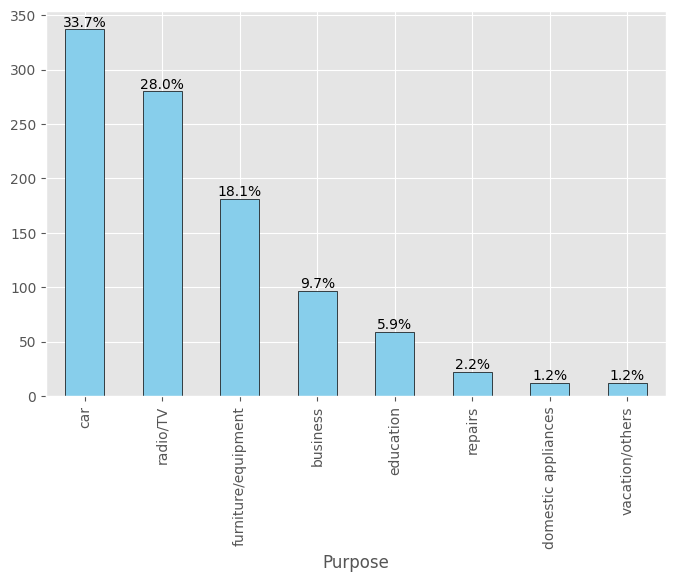

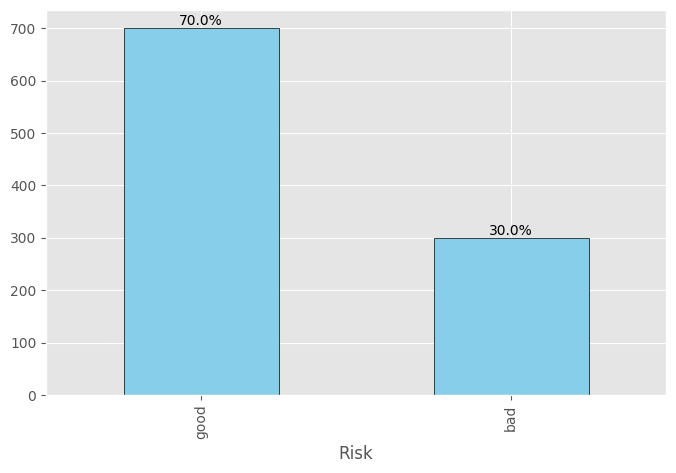

In [7]:
# Supprimer la colonne Unnamed: 0 si elle existe
df = df.drop(columns=["Unnamed: 0"], errors='ignore')

# Style d'affichage
plt.style.use('ggplot')  # Style pour un affichage plus agréable

# Fonction pour ajouter les pourcentages sur les barres
def add_percentage(ax, total):
    for p in ax.patches:
        height = p.get_height()
        if height > 0:  # Éviter les barres vides
            percentage = f"{(height / total) * 100:.1f}%"  # Calcul du pourcentage
            ax.annotate(percentage, 
                        (p.get_x() + p.get_width() / 2, height),  # Position
                        ha='center', va='bottom', fontsize=10, color='black')

# Créer des histogrammes pour chaque variable
for column in df.columns:
    plt.figure(figsize=(8, 5))  # Taille de chaque histogramme
    if df[column].dtype in ['int64', 'float64']:
        # Variables numériques
        counts, bins, patches = plt.hist(df[column], bins=30, color='skyblue', edgecolor='black')
        total = counts.sum()
        
        # Ajouter des pourcentages
        for count, patch in zip(counts, patches):
            if count > 0:  # Pour éviter les barres vides
                percentage = f"{(count / total) * 100:.1f}%"
                plt.text(patch.get_x() + patch.get_width() / 2, count, percentage,
                         ha='center', va='bottom', fontsize=10, color='black')
        
        plt.title(f"Répartition de la variable '{column}'")
        plt.xlabel(column)
        plt.ylabel("Fréquence")

    else:
        # Variables catégorielles
        value_counts = df[column].value_counts()
        total = value_counts.sum()
        ax = value_counts.plot(kind='bar', color='skyblue', edgecolor='black')
        
        # Ajouter les pourcentages
        add_percentage(ax, total)
  


## Statistiques bivariées (Avec la variable cible: 'Risk')

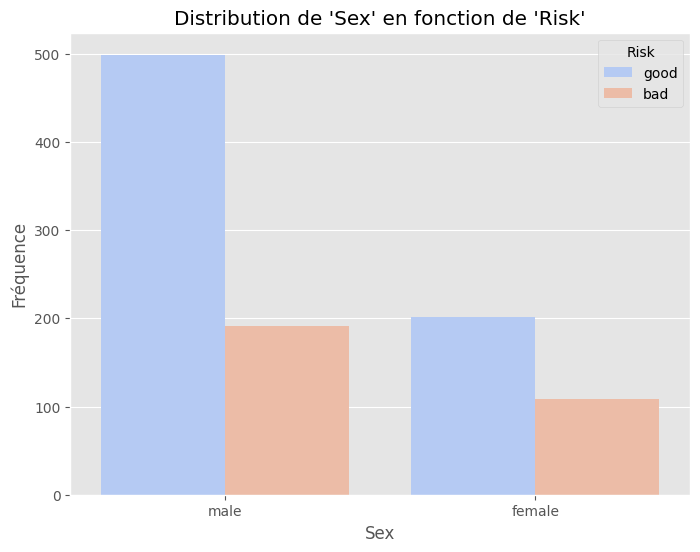

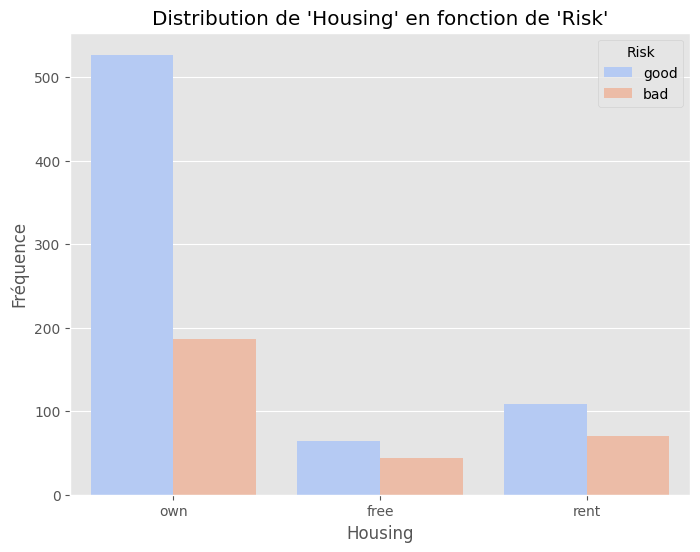

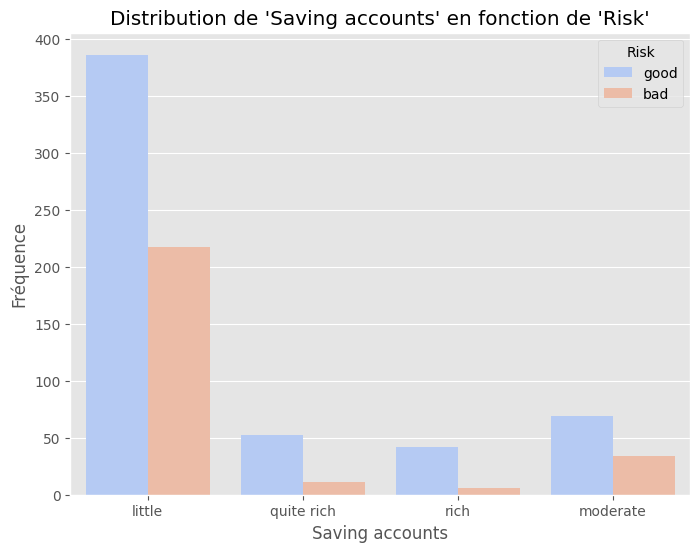

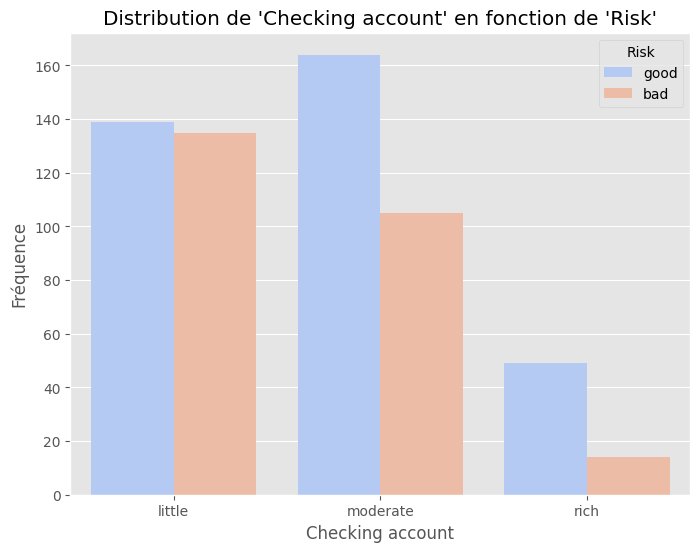

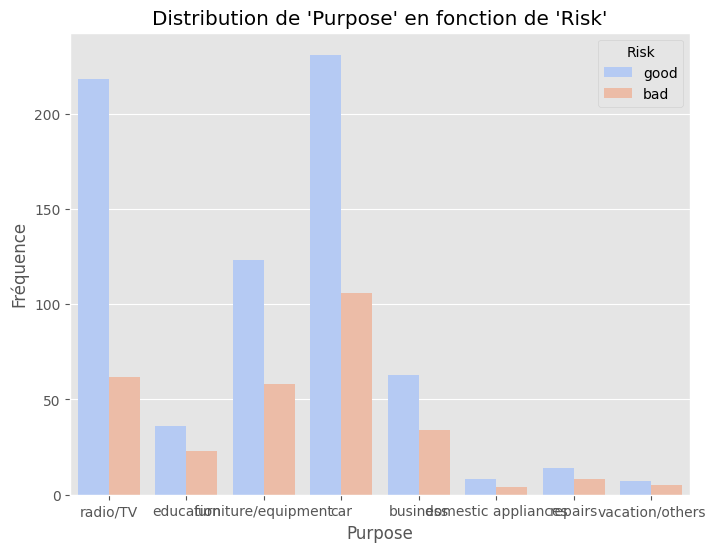

C:\Users\ilysd\AppData\Local\Temp\ipykernel_57352\1606279844.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Risk")


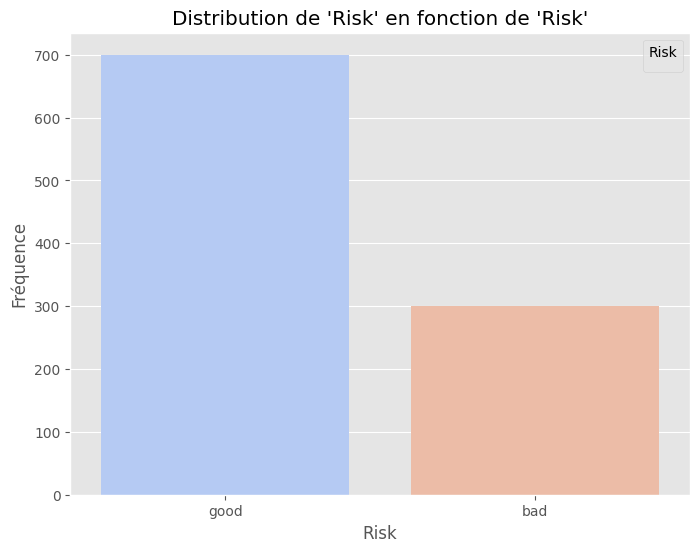

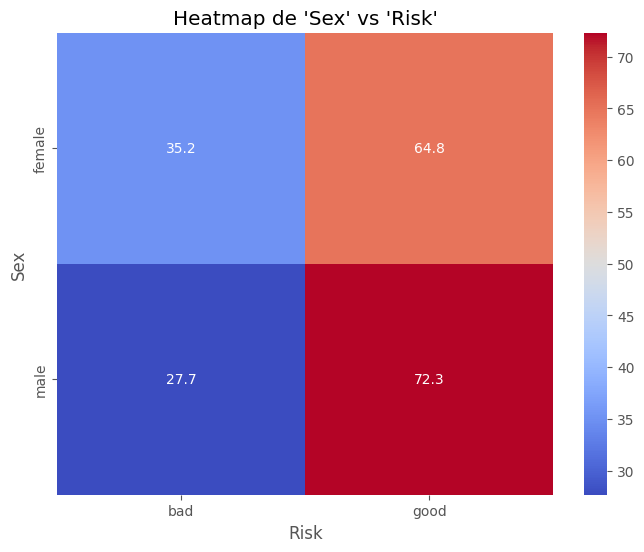

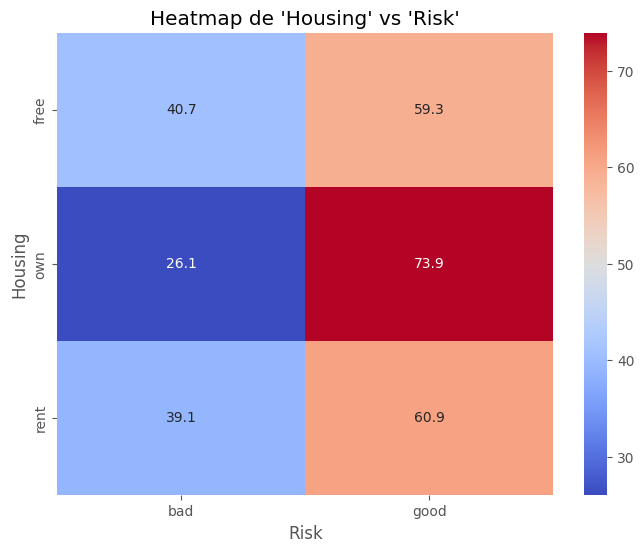

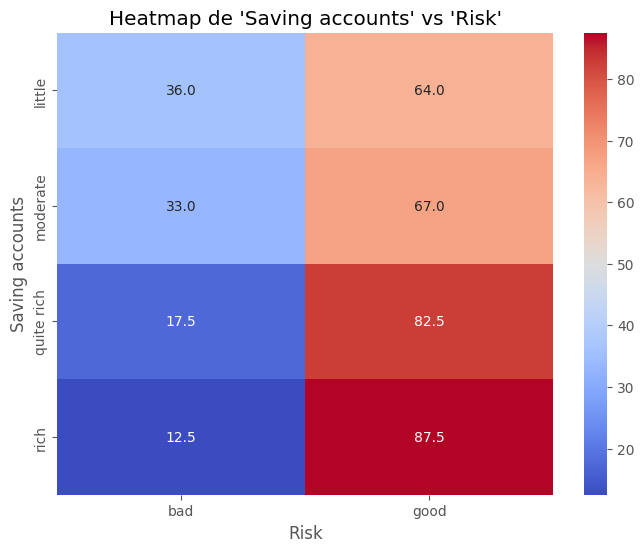

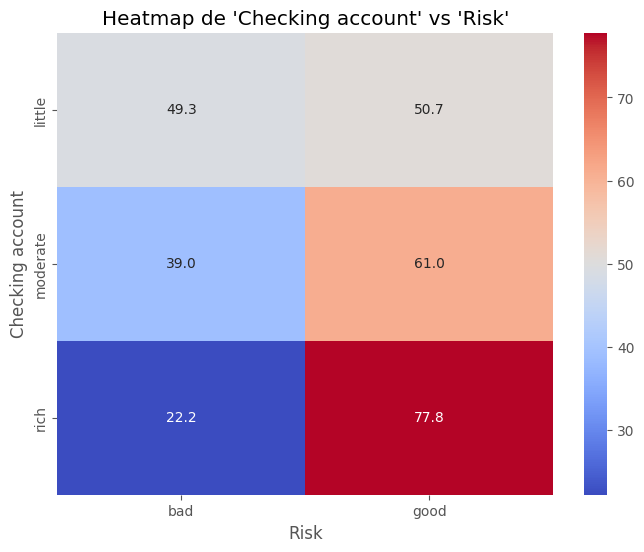

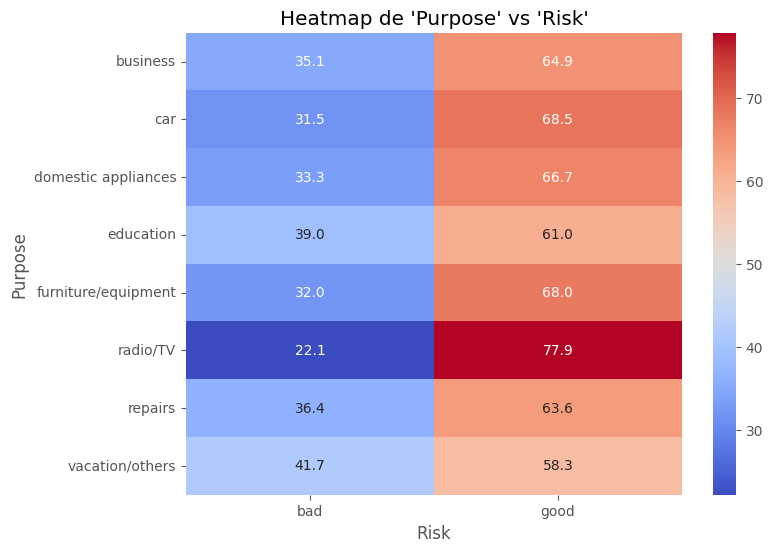

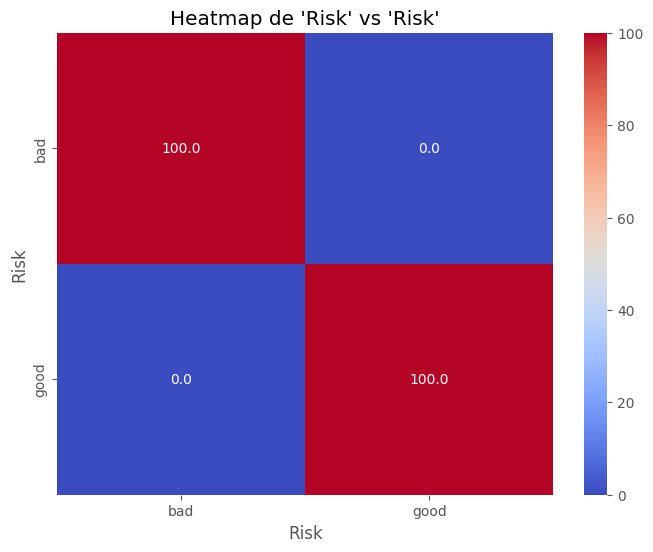

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Liste dynamique des variables catégorielles du DataFrame
cat_vars = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Si tu veux ajouter des variables spécifiques qui ne sont pas détectées automatiquement
# cat_vars.extend(['Sex', 'Job', 'Housing']) # Ajouter d'autres variables à la liste si nécessaire

# 1. Histogrammes empilés pour chaque variable catégorielle en fonction de 'Risk'
for var in cat_vars:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=var, hue='Risk', data=df, palette='coolwarm')
    plt.title(f"Distribution de '{var}' en fonction de 'Risk'")
    plt.xlabel(var)
    plt.ylabel("Fréquence")
    plt.legend(title="Risk")
    plt.show()

# 2. Heatmap de la table de contingence (crosstab) pour chaque variable catégorielle
for var in cat_vars:
    # Création de la table de contingence normalisée
    contingency_table = pd.crosstab(df[var], df['Risk'], normalize='index') * 100

    plt.figure(figsize=(8, 6))
    sns.heatmap(contingency_table, annot=True, fmt=".1f", cmap="coolwarm")
    plt.title(f"Heatmap de '{var}' vs 'Risk'")
    plt.xlabel("Risk")
    plt.ylabel(var)
    plt.show()


# Features engineering

Regroupement des variables numériques dont celles qui ont des valeurs abérrantes (Age), Création des nouvelles modalités dans les deux variables NA, Création d'un nouvelle variable interactive entre 'credit amount' et 'credit duration', pour améliorer le lien avec la variable cible.

In [13]:
df['Saving accounts'] = df['Saving accounts'].fillna('No savings')

df['Checking account'] = df['Checking account'].fillna('No checking')

#Convertir en float pour éviter les conflits de types avec pd.cut()
df['Age'] = df['Age'].astype(float)
df['Credit amount'] = df['Credit amount'].astype(float)


#Creation d'une nouvelle colonne interactive entre credit amount et duration avant leurs encodages
df['Credit_Duration_Ratio'] = df['Credit amount'] / df['Duration']

# Définir les tranches d'âge
df['Age_Group'] = pd.cut(df['Age'], bins=[20, 30, 40, float('inf')], labels=['Young', 'Adults', 'Mature-Seniors'], right=False)

#Suppresion des variables inutiles
df.drop(columns=['Checking account', 'Saving accounts', 'Age', 'Duration','Credit amount'], inplace=True)

In [11]:
# Appel la fonction qui automatise le traitement
# df = feature_engineering(df)

# print(df.head())


## V Cramer

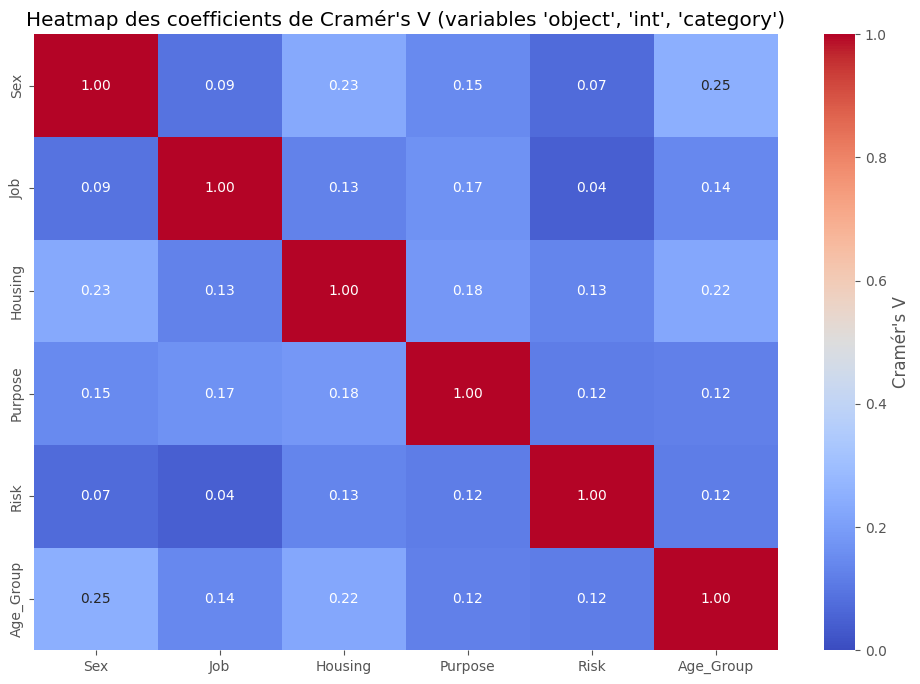

In [21]:
# Fonction pour calculer Cramér's V
def cramers_v(confusion_matrix):
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

# Filtrer les variables de types 'object', 'int' et 'category'
selected_vars = df.select_dtypes(include=['object', 'int64', 'category']).columns

# Calcul de Cramér's V entre chaque paire de variables sélectionnées
cramers_v_matrix = []

for var1 in selected_vars:
    row = []
    for var2 in selected_vars:
        if var1 == var2:
            row.append(1.0)  # Cramér's V est toujours 1 avec soi-même
        else:
            # Calcul de Cramér's V
            confusion_matrix = pd.crosstab(df[var1], df[var2])
            v = cramers_v(confusion_matrix)
            row.append(v)
    cramers_v_matrix.append(row)

# Convertir en DataFrame pour une meilleure lisibilité
cramers_v_df = pd.DataFrame(cramers_v_matrix, columns=selected_vars, index=selected_vars)

# Affichage de la heatmap pour Cramér's V
plt.figure(figsize=(12, 8))
sns.heatmap(cramers_v_df, annot=True, cmap="coolwarm", fmt=".2f", cbar_kws={'label': "Cramér's V"}, vmin=0, vmax=1)
plt.title("Heatmap des coefficients de Cramér's V (variables 'object', 'int', 'category')")
plt.show()

# Model training

Modeling avec affichage de l'arbre

2024-12-18 17:25:01,462 - INFO - Prétraitement des données par encodage one-hot.
2024-12-18 17:25:01,464 - INFO - Encodage des labels.
2024-12-18 17:25:01,465 - INFO - Séparation des données en ensembles d'entraînement et de test.
2024-12-18 17:25:01,467 - INFO - Initialisation de la recherche par validation croisée pour RandomForest.
2024-12-18 17:25:07,932 - INFO - Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
2024-12-18 17:25:07,933 - INFO - Best Cross-Validation Accuracy: 0.7093
2024-12-18 17:25:07,939 - INFO - Test Set Performance:
              precision    recall  f1-score   support

         bad       0.33      0.07      0.11        75
        good       0.70      0.94      0.80       175

    accuracy                           0.68       250
   macro avg       0.52      0.50      0.46       250
weighted avg       0.59      0.68      0.60       250

2024-12-18 17:25:07,939 - INFO - Visualisation de l'arbre de décision à l'

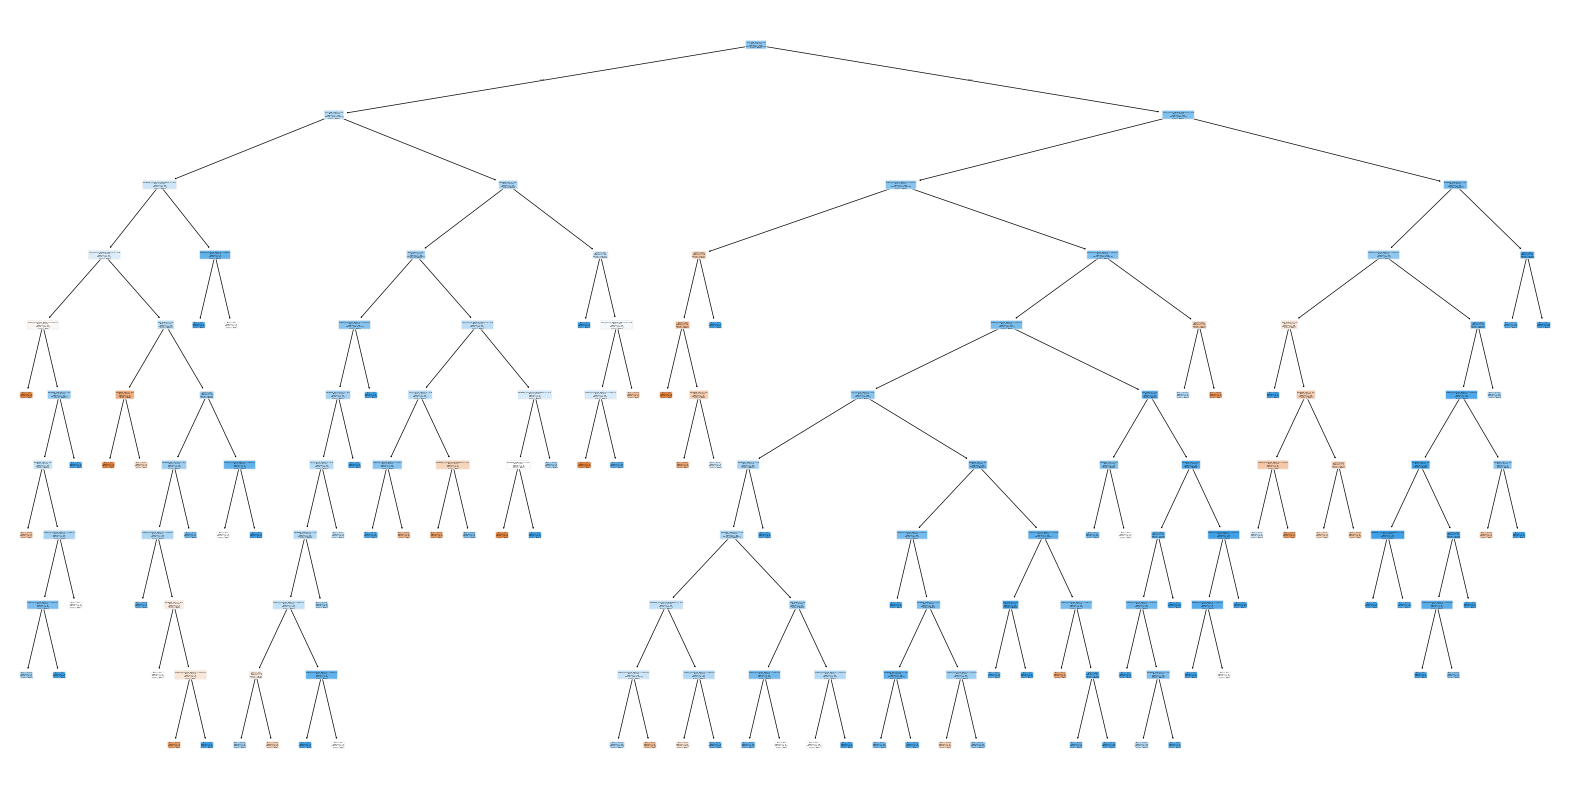

In [13]:
X = df.drop(columns=['Risk'])  # Remplace 'cible' par le nom de ta colonne cible
y = df['Risk']  # Colonne cible

# Applique l'encodage one-hot
X_processed = preprocess_data(X)

# Exemple d'utilisation
y_encoded = encode_target(y)  # Pour encoder la variable cible
X_train, X_test, y_train, y_test = split_data(X_processed, y)  # Pour séparer les données en ensembles d'entraînement et de test
grid_search = cross_validate()  # Pour définir la grille de recherche pour le RandomForest
evaluate_model(grid_search, X_train, y_train, X_test, y_test)  # Pour évaluer le modèle avec les meilleures hyperparamètres

# Modèle entraîné
best_model = grid_search.best_estimator_

# Appel pour visualiser l'arbre 0
plot_random_forest_tree(best_model, X_train, y_train, tree_index=0)


Modeling avec uniquement les metrics simples (Precision, Rappel)

In [14]:
# Entrainement et évaluation
X_train, X_test, y_train, y_test = split_data(X_processed, y)  # Pour séparer les données en ensembles d'entraînement et de test
grid_search = cross_validate()  # Pour définir la grille de recherche pour le RandomForest

# Evaluating the model using the defined function
evaluate_model(grid_search, X_train, y_train, X_test, y_test)  # Pour évaluer le modèle avec les meilleurs hyperparamètres




2024-12-18 17:25:09,133 - INFO - Séparation des données en ensembles d'entraînement et de test.
2024-12-18 17:25:09,135 - INFO - Initialisation de la recherche par validation croisée pour RandomForest.
2024-12-18 17:25:12,398 - INFO - Best Parameters: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 50}
2024-12-18 17:25:12,398 - INFO - Best Cross-Validation Accuracy: 0.7107
2024-12-18 17:25:12,405 - INFO - Test Set Performance:
              precision    recall  f1-score   support

         bad       0.38      0.04      0.07        75
        good       0.70      0.97      0.82       175

    accuracy                           0.69       250
   macro avg       0.54      0.51      0.44       250
weighted avg       0.60      0.69      0.59       250



Modeling avec tous les graphiques et metrics simples

2024-12-18 17:25:16,452 - INFO - Prétraitement des données par encodage one-hot.
2024-12-18 17:25:16,454 - INFO - Encodage des labels.
2024-12-18 17:25:16,455 - INFO - Séparation des données en ensembles d'entraînement et de test.
2024-12-18 17:25:16,456 - INFO - Initialisation de la recherche par validation croisée pour RandomForest.
2024-12-18 17:25:19,663 - INFO - Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
2024-12-18 17:25:19,663 - INFO - Best Cross-Validation Accuracy: 0.7107
2024-12-18 17:25:19,668 - INFO - Test Set Performance:
              precision    recall  f1-score   support

           0       0.39      0.09      0.15        75
           1       0.71      0.94      0.81       175

    accuracy                           0.68       250
   macro avg       0.55      0.52      0.48       250
weighted avg       0.61      0.68      0.61       250

2024-12-18 17:25:19,668 - INFO - Visualisation de l'arbre de décision à l'

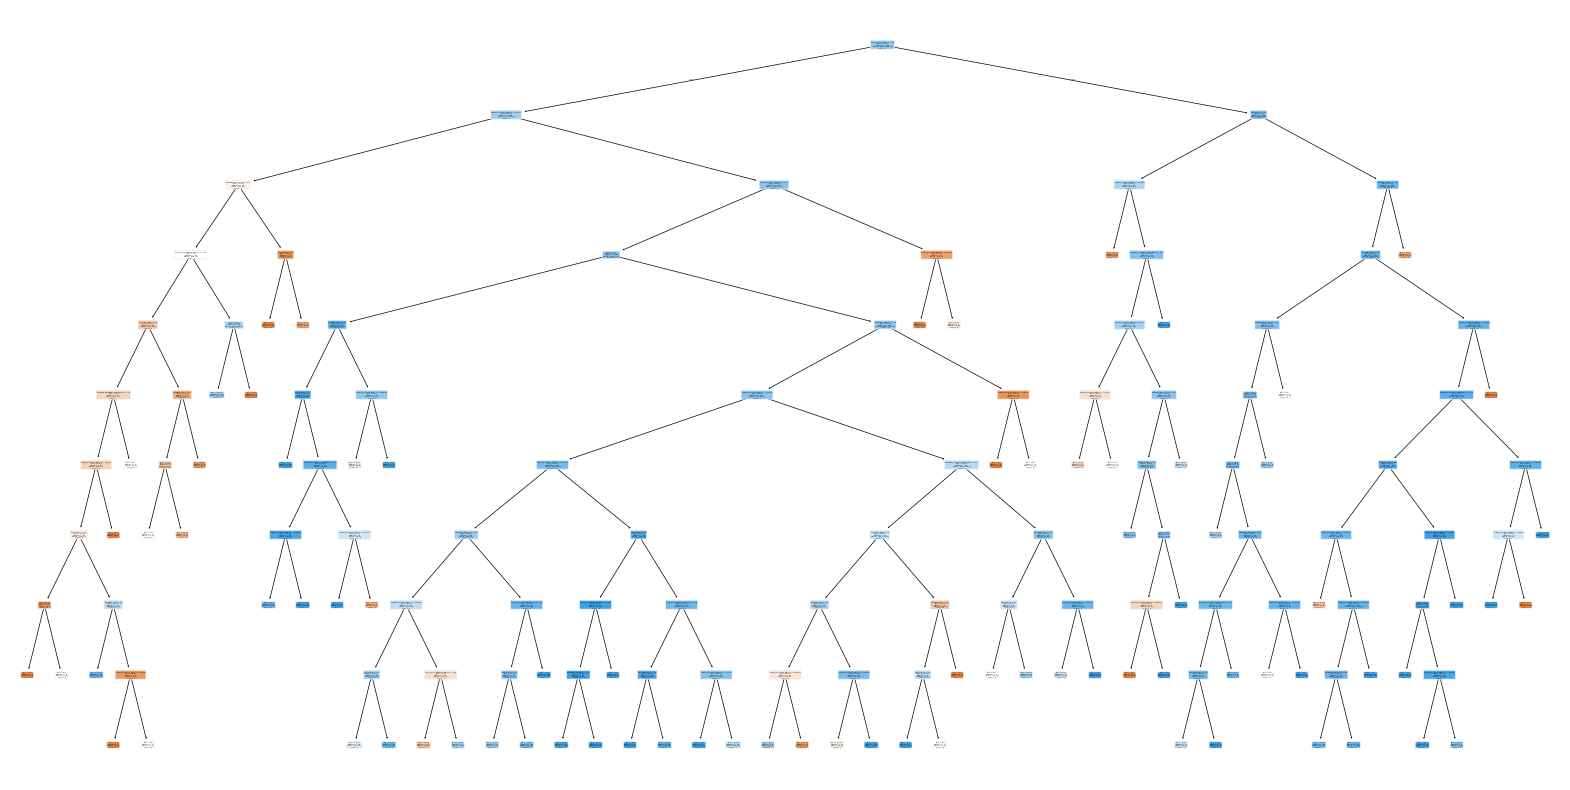

2024-12-18 17:25:20,780 - INFO - Affichage de l'importance des caractéristiques.


2024-12-18 17:25:20,804 - INFO - Affichage de la matrice de confusion.


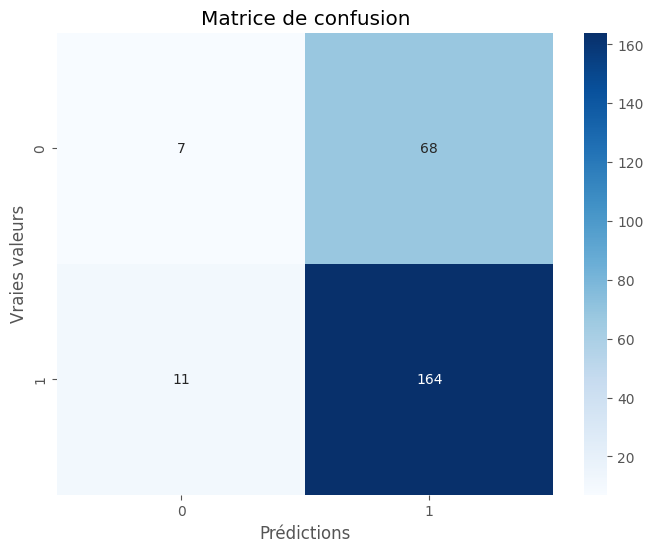

2024-12-18 17:25:20,870 - INFO - Affichage de la courbe ROC.


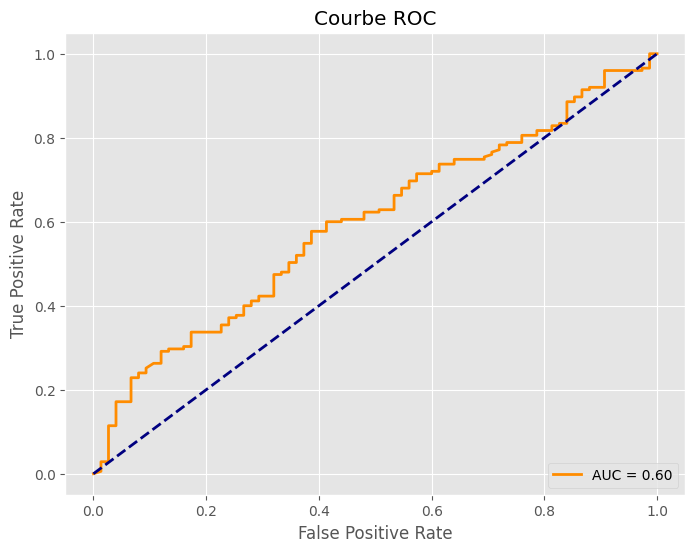

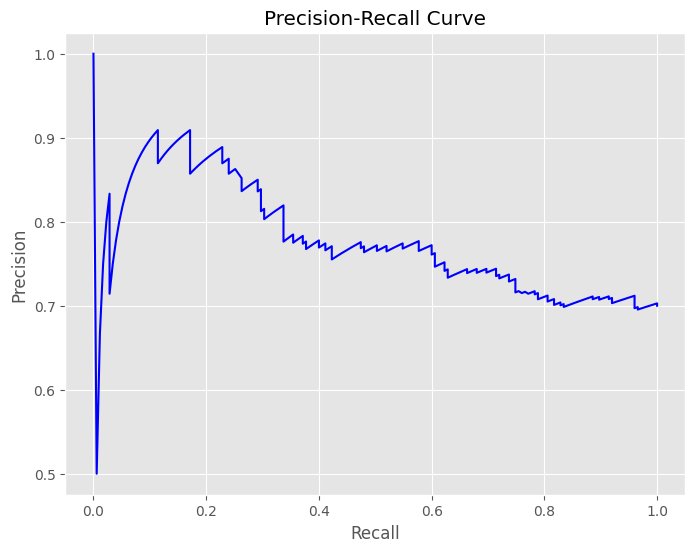

2024-12-18 17:25:20,970 - INFO - Precision-Recall Curve générée avec succès.


In [16]:

# Séparation des données
X = df.drop(columns=['Risk'])  # Remplace 'Risk' par le nom de ta colonne cible
y = df['Risk']  # Colonne cible

# Applique l'encodage one-hot
X_processed = preprocess_data(X)  # Vous devez définir ou importer cette fonction

# Encoder la variable cible
y_encoded = encode_target(y)  # Fonction d'encodage des labels

# Séparer les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = split_data(X_processed, y_encoded)  # Fonction de séparation des données

# Définir le modèle RandomForest et la grille de recherche
grid_search = cross_validate()  # Fonction de validation croisée, qui retourne un objet GridSearchCV

# Entraîner le modèle et évaluer
evaluate_model(grid_search, X_train, y_train, X_test, y_test)  # Appel de la fonction evaluate_model

# Obtenir le meilleur modèle
best_model = grid_search.best_estimator_

# Appel pour visualiser l'arbre 0
plot_random_forest_tree(best_model, X_train, y_train, tree_index=0)

# Visualiser l'importance des caractéristiques
plot_feature_importances(best_model)  # Fonction pour l'importance des features

# Prédictions sur le jeu de test
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]

# Visualiser la matrice de confusion
plot_confusion_matrix(y_test, y_pred)  # Fonction de matrice de confusion

# Visualiser la courbe ROC
plot_roc_curve(y_test, y_pred_prob)  # Fonction de courbe ROC

# Visualiser la courbe Précision/Rappel
plot_precision_recall_curve(y_test, y_pred_prob)


Creation de csv des predictions et de df cleaned & formated

In [17]:
df.to_csv('C:/Users/ilysd/Desktop/FAC/Master 2/MLops/Projet/data/formated/credits_formated.csv', index=False)


In [18]:
# Créer un DataFrame avec les prédictions et les vraies valeurs
predictions_df = pd.DataFrame({
    'True Values': y_test,  # Valeurs réelles
    'Predictions': y_pred,  # Prédictions de classes
    'Prediction Probabilities': y_pred_prob  # Probabilités de la classe positive
})

# Exporter les prédictions dans un fichier CSV
predictions_df.to_csv('C:/Users/ilysd/Desktop/FAC/Master 2/MLops/Projet/data/models/predictions_on_true.csv', index=False)
